# Курс по машинному обучению,   ВМК МГУ
## Градиентный бустинг деревьев

### Важно! О формате сдачи

* **Практически все выделенные задания из ноутбука оцениваются по системе <font color='red'>кросс-рецензирования</font>. Задания, в котором надо реализовать свой код и послать в систему, выделены здесь и в pdf отдельно**
* **В этом ноутбуке есть задание на ML-решение**
* **При решении ноутбука используйте данный шаблон. Не нужно удалять текстовые ячейки c разметкой частей ноутбука и формулировками заданий. Добавлять свои ячейки, при необходимости, конечно можно**
* **Везде, где в формулровке задания есть какой-либо вопрос (или просьба вывода), необходимо прописать ответ в ячейку (код или markdown).**
* **Наличие кода решения обязательно. Письменные ответы на вопросы без сопутствующего кода оцениваются в 0 баллов.**

**А также..**

Если в ячейке написана фраза "Вывод"/"Ответ на вопрос" итд, то ожидается ответ в виде текста (можете добавить ячейки с кодом, если считаете это необходимым, но это необязательно). Если в ячейке написано "Your code here", то ожидается ответ в виде кода (можете добавить ячейки с кодом, если считаете это необходимым, но это необязательно). Если есть и ячейка с фразой "Вывод", и ячейка с фразой "Your code here", то в ответе ожидается и код, и текст)

__В этом задании вы..:__

- Познакомитесь с несколькими новыми библиотеками машинного обучения
- Сравните между собой разные реализации градиентных бустингов
- Примените все полученные знания для получения лучшего скора на датасете фильмов




## Введение

Привет, ребятушки!

Сегодня мы с вами будем решать очень важную задачу, а именно оценивать цену поддержанных автомобилей в ряде стран. Делать мы это будем с помощью различных методов градиентного бустинга. Мы с вами узнаем, что в мире существует не только sklearn, и что существуют библиотеки, облегчающие нам задачу поиска оптимальных параметров для моделей.

**Внимание! Во всех заданиях в качестве целевой метрики используется MAE (средняя абсолютная ошибка).** Значение MAE вычисляется как

$$
  MAE = \sum_{i = 1}^N\dfrac{|a(x_i) - y_i|}{N},
$$

где $N$ - число объектов в тестовой выборке, $x_i$ - вектор признаков i-го объекта, $a(x_i)$ - предсказание на i-ом объекте, $y_i$ - значение целевого признака на i-м объекте.

## Установка дополнительных библиотек.

В этом задании нам понадобятся три бибиотеки, которыми вы ранее не пользовались в этом курсе, а именно:

**XGBoost**: Документация [здесь](https://xgboost.readthedocs.io/en/stable/).<br />
**LightGBM**: Документация [здесь](https://lightgbm.readthedocs.io/en/latest/index.html). Также дополнительно про установку [тут](https://pypi.org/project/lightgbm/).<br />
**Catboost**: Документация [здесь](https://catboost.ai/en/docs/). Можно найти также некоторую информацию на русском [тут](https://habr.com/ru/company/otus/blog/527554/).<br />
**HyperOpt**: Документация [здесь](http://hyperopt.github.io/hyperopt/). <br />

Все библиотеки легко ставятся через pip (либо альтернативные установщики вроде conda).


## Как правильно перебирать параметры

В этом ноутбуке мы будем несколько раз заниматься поиском оптимальных параметров для градиентного бустинга, перебирая задания по заданной сетке. В этом задании от Вас не будет требоваться найти самые лучшие параметры, но всё равно важно правильно составлять сетку для перебора. Для этого нужно понимать суть параметров и их смысл.



**learning_rate** -- темп обучения нашего метода. Для этого метода сетка перебора должна быть логарифмической, т.е. перебирать порядковые значения (к примеру, [1e-3, 1e-2, 1e-1, 1]). В большинстве случаев достаточно перебрать значения от 1e-5 до 1.<br />
**max_depth** -- максимальная глубина деревьев в ансамбле. Вообще говоря, эта величина зависит от числа признаков, но обычно лучше растить небольшие деревья. К примеру, библиотека CatBoost, которую мы будем исследовать сегодня, рекомендует перебирать значения до 10 (и уточняется, что обычно оптимальная глубина лежит от 6 до 10).<br />
**n_estimators** -- количество деревьев в ансамбле. Обычно стоит перебирать с каким-то крупным шагом (можно по логарифмической сетке). Здесь важно найти баланс между производительностью, временем обучения и качеством. Обычно нескольких тысяч деревьев бывает достаточно.<br />

Учтите, что в реальных задачах необходимо следить за тем, что оптимальные значения параметров не попадают на границы интервалов, т.е. что вы нашли хотя бы локальный минимум. Если Вы перебрали значения параметра от 1 до 10 и оказалось, что 10 - оптимальное значение, значит следует перебрать и бОльшие числа, чтобы убедиться, что качество не улучшается дальше (или по крайней мере убедиться, что рост качества сильно замедляется и на сильное улучшения рассчитывать не стоит.


## Подготовка датасета

Все библиотеки, используемые сегодня, мы будем проверять на одних и тех же параметрах: n_estimators=1000, max_depth=5, learning_rate=0.1. Таким образом мы устанавливаем, соответственно, число деревьев в ансамбле равным 1000, ограничиваем максимальную глубину деревьев 5 и устанавливаем темп обучения равным 0.1. Создадим сразу словарь, чтобы передавать эти параметры создаваемым регрессорам (если вдруг не знали, словарь можно передавать как параметры, поставив перед ним **).

Эти параметры мы вынесем в отдельную переменную `test_parameters`.

<span style="color:red">Загрузите датасет, с которым мы будем работать. Его можно найти на платформе cv-gml.ru, в задании `Град. бустинг (ML)`, по ссылке `Дополнительные файлы для решения`. Если Вы решите сохранить этот файл не рядом с ноутбуком, Вы можете исправить путь к этому файлу во второй ячейке ноутбука (в строке с `read_csv`).</span>

При желании можно почитать про этот датасет на платформе kaggle: [ссылка на данные](https://www.kaggle.com/bushnag/cars-in-the-middle-east?select=dataframe_YesIndex_YesHeader_C.csv). <span style="color:red"> Не скачивайте датасет из kaggle для выполнения ноутбука, поскольку его могут изменить.</span> Нас интересует файл dataframe_YesIndex_YesHeader_C.csv, поскольку он уже хорошо предобработан (хотя, конечно, датасаентисты должны сами уметь это делать, но ладно).
Давайте попробуем загрузить датасет в память и посмотреть, как он выглядит.

In [1]:
%matplotlib inline
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import mean_absolute_error, make_scorer

from hyperopt import hp, tpe, Trials
from hyperopt.fmin import fmin
from hyperopt.pyll import scope

from xgboost import XGBRegressor

from lightgbm import LGBMRegressor

from catboost import CatBoostRegressor

import matplotlib.pyplot as plt

import pandas as pd

import numpy as np

import time

In [2]:
test_parameters = {"n_estimators": 1000, "max_depth": 5, "learning_rate":0.1}

df = pd.read_csv('dataframe_YesIndex_YesHeader_C.csv', index_col=0)
df.head()

,Engine Capacity,Cylinders,Drive Type,Fuel Tank Capacity,Fuel Economy,Fuel Type,Horsepower,Torque,Transmission,Top Speed,...,Acceleration,Length,Width,Height,Wheelbase,Trunk Capacity,name,price,currency,Country
0,1.2,3,0,42.0,4.9,0,76,100.0,0,170,...,14.0,4.245,1.670,1.515,2.550,450.0,Mitsubishi Attrage 2021 1.2 GLX (Base),34099.0,0,0
1,1.2,3,0,42.0,4.9,0,76,100.0,0,170,...,14.0,4.245,1.670,1.515,2.550,450.0,Mitsubishi Attrage 2021 1.2 GLX (Base),34099.0,0,0
2,1.4,4,0,45.0,6.3,0,75,118.0,1,156,...,16.0,3.864,1.716,1.721,2.513,2800.0,Fiat Fiorino 2021 1.4L Standard,41250.0,0,0
3,1.6,4,0,50.0,6.4,0,102,145.0,0,180,...,11.0,4.354,1.994,1.529,2.635,510.0,Renault Symbol 2021 1.6L PE,44930.0,0,0
4,1.5,4,0,48.0,5.8,0,112,150.0,0,170,...,10.9,4.314,1.809,1.624,2.585,448.0,MG ZS 2021 1.5L STD,57787.0,0,0


### Задание 0 (без проверки, 0 баллов)

Посмотрите на цены автомобилей. Попробуйте понять, написаны они в одной валюте или нет. Если нет -- будут ли у нас серьезные проблемы при использовании деревьев? Стоит ли нам что-то сделать для того, чтобы нивелировать эту проблему?


В глаза бросаются две проблемы: у нас имеется информация о производителе автомобиля, скрытая в текстовой переменной модели автомобиля (нет отдельного признака). Также имеются некоторые категориальные переменные. Со всем этим безобразием надо что-то сделать.

### **Задание 1 (кросс-проверка, 3 балла)**
**Данные**: датасет со стоимостью поддержанных автомобилей  
**Цели**: В данном задании следует выполнить следующие пункты (выполнять можно в любом порядке)
1. Изучить датасет, проверить наличие пропусков. При необходимости заменить их на среднее значение признака.
3. Добавить столбец brand с информацией о производителе автомобиля (для простоты можно взять первое слово в названии модели)
4. Решить, какие признаки Вы хотите сделать категориальными. Конвертировать выбранные категориальные столбцы в тип category. 
5. Создать датасет А с категориальными признаками в виде категорий. Для этого необходимо создать вектор целевых значений (столбец цен автомобилей) и матрицу признаков с категориальными переменными в виде категорий (получается путем удаления только целевой переменной из матрицы с данными). Дополнительно стоит создать список с названиями и индексами столбцов категориальных переменных (поможет в будущем).
6. Создать датасет B без категориальных признаков. Для этого необходимо создать вектор целевых значений (столбец цен автомобилей) и удалить из матрицы признаков столбец с целевыми переменными, а также все категориальные переменные.
8. Создать датасет C с категориальными признаками в виде one-hot encoding. Для этого необходимо создать вектор целевых значений (столбец цен автомобилей), удалить из матрицы признаков столбец с целевыми переменными и все категориальными переменные, а затем добавить новые признаки, соответствующие one-hot encoding категориальных переменных (здесь вам поможет функция `pd.get_dummies`).
9. Разбить датасеты на тренировочное и тестовое множества, используя `train_test_split(X, y, test_size=0.25, random_state=0)` (зафиксировав random_seed мы получим одинаковое разбиение на обучение/тест для всех трёх выборок).

In [3]:
datasets = {'A' : None, 'B': None, 'C': None}

In [4]:
# 1
for col in df.columns:
    if sum(pd.isna(df[col])):
        df[col].fillna(df[col].mean(), inplace=True)

# 2
df['brand'] = df['name'].apply(lambda s: s.split(' ')[0])
df.drop('name', axis=1, inplace=True)

#
cat_names = ['Drive Type', 'Fuel Type', 'Transmission', 'currency', 'Country', 'brand']
cat_idx = [list(df.columns).index(x) for x in cat_names]
ncat_names = [col for col in df.columns if col not in cat_names]
ncat_names.remove('price')

# 3
df[cat_names] = df[cat_names].astype('category')

#
df_cat = df[cat_names]
df_ncat = df[ncat_names]
y = df['price']
par = {'test_size':0.25, 'random_state':0}

# 4,7
datasets['A'] = train_test_split(df_cat, y, **par)

# 5,7
datasets['B'] = train_test_split(df_ncat, y, **par)

# 6,7
datasets['C'] = train_test_split(pd.concat([df_ncat, pd.get_dummies(df_cat)], axis = 1), y, **par)

Итак, кажется, что у нас всё готово для того, чтобы начать искать ответы на волнующие нас вопросы. Начнем со столь любимой нами библиотеки, а именно...

## Градиентный бустинг со sklearn

Естественно, в sklearn имеется реализация градиентного бустинга, которая хранится в sklearn.ensemble.GradientBoostingRegressor. Преимущественно данным классом пользуются в учебных заданиях, поскольку в реальных задачах предпочтение отдаётся другим библиотекам. Давайте попробуем понять, заслуженно ли градиентный бустинг в sklearn не пользуется популярностью.

FYI: в sklearn имеется также реализация GradientBoostingClassifier для задач классификации, но пользоваться им мы сегодня не будем.

GradientBoostingRegressor из коробки не умеет работать с категориальными признаками. Мы к этому уже подготовились, закодировав наши признаки.

### **Задание 2 (кросс-проверка, 2 балла)**:

**Данные**: датасет со стоимостью поддержанных автомобилей    
**Метрика**: MAE    
**Цели**: В данном задании следует выполнить следующие пункты:    
1. Обучить sklearn.ensemble.GradientBoostingRegressor на датасетах B и C, используя параметры n_estimators=1000, max_depth=5, learning_rate=0.1 (наши `test_parameters`). Замерьте время обучения, получите предсказания данных моделей на тестовом множестве.
2. Обучить sklearn.ensemble.GradientBoostingRegressor на датасете B (можно и на C, если позволяют вычислительные ресурсы), используя кросс-валидацию на тренировочном множестве и подбирая значения для параметров n_estimators, learning_rate и max_depth. для простоты можете воспользоваться GridSearchCV. При необходимости можно оптимизировать параметры по одному, а не все сразу. Выведите лучшие параметры. Получите предсказания лучшей модели (с лучшими параметрами) на тестовом множестве. Для ускорения процесса не забудьте воспользоваться n_jobs.
3. Посчитать MAE для полученных предсказаний на тренировочном и тестовом множествах (можно воспользоваться sklearn.metrics.mean_absolute_error).
5. Вывести результаты и время в таблице DataFrame.
4. Сделайте выводы. Оцените полезность категориальных переменных и поиска оптимальных параметров. Оцените время, затраченное на обучение. Попробуйте дать оценку получившемуся MAE: оно большое или маленькое?


In [5]:
df_skl = pd.DataFrame(columns=['Dataset', 'n_estimators', 'max_depth', 'learning_rate', 'Time', 'MAE'])
# your cool code here

In [6]:
grid = {'learning_rate':[0.001, 0.01, 0.1], 
        'max_depth':[3, 4, 5, 6, 7, 9, 11], 
        'n_estimators': [10, 50, 150, 500, 1000, 1500, 2000, 3000, 5000]}

In [7]:
def show_results(data, df_name, model, model_name, ret_str = False, cat_names=None):
    X_train, X_test, y_train, y_test = data

    start = time.time()
    if cat_names:
        model.fit(X_train, y_train, cat_features=cat_names)
    else:
        model.fit(X_train, y_train)
    t = time.time() - start

    y_pred = model.predict(X_test)
    MAE = mean_absolute_error(y_pred, y_test)
    MAE_train = mean_absolute_error(model.predict(X_train), y_train)
    
    d = {'Time' : t, 'MAE' : MAE}
    
    res = 'Model: ' + model_name + '\nDataset ' + df_name + '\nTest parameters\nВремя обучения: '\
    + str(t) + '\nTest MAE: ' + str(MAE) + '\nTrain MAE: ' + str(MAE_train) + '\n'
    
    if ret_str:
        return (d, res)
    else:
        print(res)
        return d

In [8]:
def boost_grid_search(data, df_name, regressor, parameters, model_name, n_jobs=None):
    X_train, X_test, y_train, y_test = data
    
    start = time.time()
    searcher.fit(X_train, y_train)
    best_parameters = searcher.best_params_
    best_model = regressor.set_params(**best_parameters)
    best_model.fit(X_train, y_train)
    t = time.time() - start
    
    y_pred = best_model.predict(X_test)
    MAE = mean_absolute_error(y_pred, y_test)
    MAE_train = mean_absolute_error(best_model.predict(X_train), y_train)
    
    print('Model: ', model_name)
    print('Dataset', df_name)
    print('Лучшие параметры:', best_parameters)
    print('Время обучения:', t)
    print('Test MAE:', MAE)
    print('Train MAE:', MAE_train)
    print()
    
    d = {'Time' : t, 'MAE' : MAE}
    return (best_parameters, d)

In [9]:
regressor = GradientBoostingRegressor(**test_parameters)
gb_par = {'parameters' : grid, 'n_jobs' : -1, 'model_name' : 'GradientBoostingRegressor'}

for sym in ['B', 'C']:
    res = show_results(datasets[sym], sym, regressor, 'GradientBoostingRegressor')
    row = {'Dataset' : sym, **test_parameters, **res}
    df_skl = df_skl.append(row, ignore_index=True)

for sym in ['B', 'C']:
    param, res = boost_grid_search(datasets[sym], sym, GradientBoostingRegressor(), **gb_par)
    row = {'Dataset':sym, **param, **res}
    df_skl = df_skl.append(row, ignore_index=True)

Model: GradientBoostingRegressor
Dataset B
Test parameters
Время обучения: 16.49339747428894
Test MAE: 123248.80010132403
Train MAE: 91885.18887320269

Model: GradientBoostingRegressor
Dataset C
Test parameters
Время обучения: 21.207964420318604
Test MAE: 17929.773520438106
Train MAE: 4505.48524198978

Model:  GradientBoostingRegressor
Dataset B
Лучшие параметры: {'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 1000}
Время обучения: 1532.5626430511475
Test MAE: 121957.55512500029
Train MAE: 103260.65940840726

Model:  GradientBoostingRegressor
Dataset C
Лучшие параметры: {'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 5000}
Время обучения: 3221.056554079056
Test MAE: 16989.454786096965
Train MAE: 5338.960945045443



In [10]:
df_skl.set_index('Dataset', inplace=True)
df_skl

,n_estimators,max_depth,learning_rate,Time,MAE
Dataset,,,,,
B,1000,5,0.10,16.493397,123248.800101
C,1000,5,0.10,21.207964,17929.773520
B,1000,6,0.01,1532.562643,121957.555125
C,5000,6,0.01,3221.056554,16989.454786


**Ваши выводы:**  
1) Ошибка сильно уменьшаяется (на порядок), если категориальные признаки не удалять, а использовать one-hot encoding категориальных переменных.  
2) Поиск оптимальных параметров требует больше времени, чем обучение модели с тестовыми параметрами, но в процентном соотношении улучшение получается не очень большое.  
3) МАЕ получается большое.

И так, sklearn предлагает нам привычный и простой способ тренировки моделей. Однако, для градиентного бустинга существует множество эвристик и трюков, помогающих улучшить результаты. И одна из библиотек, реализующая улучшенную версию бустинга, называется xgboost.

## Градиентный бустинг с XGBoost

XGBoost стала достаточно популярной библиотекой, которая позволяет добиться хороших результатов без особых усилий (во всяком случае, так гласят легенды). И у нас для вас две новости: хорошая и плохая. Хорошая – xgboost, хоть и является сторонней библиотекой, сохраняет интерфейс sklearn и даже прекрасно работает с GridSearchCV. Плохая – она тоже не умеет из коробки работать с категориальными признаками. Ну что же, давайте пощупаем это безобразие. На этот раз нас интересует класс xgboost.XGBRegressor.

Update: относительно недавно в xgboost появилась экспериментальная поддержка категориальных переменных, которая еще не добавлена в стабильную версию, поэтому ею мы пользоваться пока не будем.

### Задание 3 (кросс-проверка, 2 балла):
**Данные**: датасет со стоимостью поддержанных автомобилей  
**Метрика**: MAE  
**Цели**: В данном задании следует выполнить следующие пункты:  
1. Обучить xgboost.XGBRegressor на датасетах B и C, используя параметры n_estimators=1000, max_depth=5, learning_rate=0.1 (наши `test_parameters`). Замерьте время обучения. Получите предсказания данных моделей на тестовом множестве.
2. Обучить xgboost.XGBRegressor на датасетах B и C, используя кросс-валидацию на тренировочном множестве и подбирая значения для параметров n_estimators, learning_rate и max_depth (для простоты можете воспользоваться GridSearchCV). При необходимости можно оптимизировать параметры по одному, а не все сразу. Замерьте время перебора, получите предсказания лучшей модели (с лучшими параметрами) на тестовом множестве. В этом случае устанавливать n_jobs у GridSearchCV не рекомендую, поскольку xgboost сам умеет захватывать все доступные ресурсы, и если GridSearchCV начнет их размножать, то последствия будут печальны.
3. Посчитать MAE для полученных предсказаний на тренировочном и тестовом множествах (можно воспользоваться sklearn.metrics.mean_absolute_error).
1. Выведите результаты и время в таблице DataFrame.
4. Сделайте выводы. Оцените полезность категориальных переменных и поиска оптимальных параметров. Оцените время, затраченное на обучение. Сравните результаты со sklearn.

In [11]:
df_xgb = pd.DataFrame(columns=['Dataset', 'n_estimators', 'max_depth', 'learning_rate', 'Time', 'MAE'])
# your perfect code here

In [12]:
xgb_par = {'parameters' : grid, 'model_name' : 'XGBRegressor'}

for sym in ['B', 'C']:
    res = show_results(datasets[sym], sym, XGBRegressor(**test_parameters), 'XGBRegressor')
    row = {'Dataset' : sym, **test_parameters, **res}
    df_xgb = df_xgb.append(row, ignore_index=True)

for sym in ['B', 'C']:
    param, res = boost_grid_search(datasets[sym], sym, XGBRegressor(), **xgb_par)
    row = {'Dataset':sym, **param, **res}
    df_xgb = df_xgb.append(row, ignore_index=True)

Model: XGBRegressor
Dataset B
Test parameters
Время обучения: 2.2844321727752686
Test MAE: 123194.88893186334
Train MAE: 92312.89114247818

Model: XGBRegressor
Dataset C
Test parameters
Время обучения: 3.463129758834839
Test MAE: 18453.964720307737
Train MAE: 5601.3844222782645

Model:  XGBRegressor
Dataset B
Лучшие параметры: {'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 50}
Время обучения: 1700.7215836048126
Test MAE: 116922.9571023506
Train MAE: 122437.91155084978

Model:  XGBRegressor
Dataset C
Лучшие параметры: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 5000}
Время обучения: 3982.3324892520905
Test MAE: 16404.52029978434
Train MAE: 2273.7087710731907



In [13]:
df_xgb.set_index('Dataset', inplace=True)
df_xgb

,n_estimators,max_depth,learning_rate,Time,MAE
Dataset,,,,,
B,1000,5,0.10,2.284432,123194.888932
C,1000,5,0.10,3.463130,18453.964720
B,50,6,0.01,1700.721584,116922.957102
C,5000,7,0.10,3982.332489,16404.520300


**Ваши выводы:**  
1) Ошибка сильно уменьшаяется (на порядок), если категориальные признаки не удалять, а использовать one-hot encoding категориальных переменных.  
2) Поиск оптимальных параметров требует больше времени, чем обучение модели с тестовыми параметрами, но в процентном соотношении улучшение получается не очень большое.  
3) Времени на обучение и на подбор оптимальных параметров требуется немного больше, чем для обучения бустинга из sklearn.  
4) Результаты после подбора оптимальных параметров немного лучше, чем в sklearn.

Таким вот несложным образом нам удалось воспользоваться еще одной библиотекой. Давайте перейдем к третьей библиотеке, которую мы сегодня изучим, и называется она lightgbm.

## Градиентный бустинг в lightgbm

Про Lightgbm легенды гласят, что она очень быстрая и легкая: что самый большой датасет она без проблем переварит за относительно небольшое время. А еще её разрабатывали не хухры кто, а сами мелкомягкие, так что попробовать её определённо стоит. На этот раз у нас вновь две новости, две хороших и две плохих. Первая хорошая — lightgbm тоже работает с GridSearchCV. Вторая хорошая — lightgbm умеет из коробки работать с категориальными признаками! Плохая — делает она это немного нетривиально (не зря я просил вас запомнить категориальные переменные!). Вторая плохая — да, нам придётся этим пользоваться.

Внимание! LightGBM может писать сотню радостных сообщений о том, что он увидел ваши categorical_feature и использует их. При желании можете заглушать эти оповещения, ибо в случае перебора параметров их становится слишком много. (заклинание для заглушения: `warnings.filterwarnings("ignore")`)

### Задание 4 (кросс-проверка, 3 балла):
**Данные**: датасет со стоимостью поддержанных автомобилей  
**Метрика**: MAE  
**Цели**: В данном задании следует выполнить следующие пункты:  
1. В случае датасета, сохраненном в numpy, lightgbm требует, чтобы категории были закодированы целыми числами от 0 до числа признаков(e.g. ['a', 'b', 'a'] -> [0, 1, 0]). Сделайте это для датасета A. Если вы используете pandas, то для датасета A достаточно установить соответствующие столбцы типа "категория", тогда categorical_feature='auto' сам всё подхватит.
2. Обучить lightgbm.LGBMRegressor на датасетах A, B и C, используя параметры используя параметры n_estimators=1000, max_depth=5, learning_rate=0.1. В случае датасета A, передайте в функцию fit индексы/имена категориальных признаков. Замерьте время обучения, получите предсказания данных моделей на тестовом множестве.
3. Обучить lightgbm.LGBMRegressor на датасетах A, B и C, используя кросс-валидацию на тренировочном множестве и подбирая значения для параметров n_estimators, learning_rate и max_depth (для простоты можете воспользоваться GridSearchCV). Замерьте время, потраченное на поиск оптимальных параметров(вновь не советую использовать n_jobs). Замерьте время перебора, получите предсказания лучшей модели (с лучшими параметрами) на тестовом множестве.
4. Посчитать MAE для полученных предсказаний на тренировочном и тестовом множествах (можно воспользоваться sklearn.metrics.mean_absolute_error). Сделайте выводы и полезности использования категориальных переменных и поиска оптимальных параметров.
5. Вывести результаты и время в таблице DataFrame.

In [14]:
import warnings
warnings.filterwarnings("ignore")

df_lightgbm = pd.DataFrame(columns=['Dataset', 'n_estimators', 'max_depth', 'learning_rate', 'Time', 'MAE'])

# your great code here

In [15]:
for sym in ['A', 'B', 'C']:
    res = show_results(datasets[sym], sym, LGBMRegressor(**test_parameters), 'LGBMRegressor')
    row = {'Dataset' : sym, **test_parameters, **res}
    df_lightgbm = df_lightgbm.append(row, ignore_index=True)

for sym in ['A', 'B', 'C']:
    param, res = boost_grid_search(datasets[sym], sym, LGBMRegressor(), grid, 'LGBMRegressor')
    row = {'Dataset':sym, **param, **res}
    df_lightgbm = df_lightgbm.append(row, ignore_index=True)

Model: LGBMRegressor
Dataset A
Test parameters
Время обучения: 0.6569986343383789
Test MAE: 54478.06883522632
Train MAE: 47325.122714427656

Model: LGBMRegressor
Dataset B
Test parameters
Время обучения: 0.3170006275177002
Test MAE: 122524.86849167927
Train MAE: 97464.81521657514

Model: LGBMRegressor
Dataset C
Test parameters
Время обучения: 0.3880014419555664
Test MAE: 31347.700217187903
Train MAE: 21020.38395510106

Model:  LGBMRegressor
Dataset A
Лучшие параметры: {'learning_rate': 0.01, 'max_depth': 11, 'n_estimators': 1500}
Время обучения: 578.8979601860046
Test MAE: 49427.74456285335
Train MAE: 50136.82532381543

Model:  LGBMRegressor
Dataset B
Лучшие параметры: {'learning_rate': 0.01, 'max_depth': 11, 'n_estimators': 3000}
Время обучения: 399.0252859592438
Test MAE: 122660.7617575561
Train MAE: 102218.12054985194

Model:  LGBMRegressor
Dataset C
Лучшие параметры: {'learning_rate': 0.1, 'max_depth': 11, 'n_estimators': 3000}
Время обучения: 559.0822563171387
Test MAE: 23990.4744

**Ваши выводы:**  
1) Использование категориальных переменных даёт в два раза меньшую ошибку, чем их отбрасывание, но всё ещё проигрывает использованию закодированных категориальных признаков вместе с некатегориальными (Датасет С).  
2) Время обучения на всех трех датасетах примерно одиноково.  
3) Поиск оптимальных параметров требует больше времени, но даёт результаты, близкие к результатам, полученным для моделей с тестовыми параметрами.

In [16]:
df_lightgbm.set_index('Dataset', inplace=True)
df_lightgbm

,n_estimators,max_depth,learning_rate,Time,MAE
Dataset,,,,,
A,1000,5,0.10,0.656999,54478.068835
B,1000,5,0.10,0.317001,122524.868492
C,1000,5,0.10,0.388001,31347.700217
A,1500,11,0.01,578.897960,49427.744563
B,3000,11,0.01,399.025286,122660.761758
C,3000,11,0.10,559.082256,23990.474440


Как вы видите, иногда можно не возиться с OHE, а позволить библиотекам самим это сделать (хотя иногда при этом приходится повозиться с самими данными, чтобы библиотека съела данные).

Итак, мы с вами почти стали мастерами градиентного бустинга. Переходим к последней звезде нашего хит-парада.



## Градиентный бустинг в catboost

Библиотека, созданная в тёмных подвалах яндекса. По легендам эта библиотека умеет работать с категориальными данными, быстрая, эффективная, легко настраивается, из коробки понимает текстовые признаки в задачах классификации и спасла Брюса Уиллиса. Давайте проверим.
Вас, наверное, не удивить тем, что эта библиотека работает с GridSearchCV, но им мы пользоваться не будем. В catboost существует своя реализация перебора параметров, и мы попробуем им воспользоваться (ура, разнообразие!). В качестве регрессора нас интересует catboost.CatBoostRegressor.

Внимание! Эта библиотека еще более болтлива, чем lightgbm, но это (почти) полностью лечится с помощью verbose. К сожалению, отключением warnings её не сделать молчаливее. А еще эта библиотека может неожиданно создать вам парочку новых папок.

### Задание 5 (кросс-проверка, 3 балла):
**Данные**: датасет со стоимостью поддержанных автомобилей  
**Метрика**: MAE  
**Цели**: В данном задании следует выполнить следующие пункты:  
1. Обучить catboost.CatBoostRegressor на датасетах A, B и C, используя параметры используя параметры n_estimators=1000, max_depth=5, learning_rate=0.1. В случае датасета A, передайте на вход методу fit/конструктору параметр cat_features, содержащий имена/индексы категориальных переменных. В данном случае переводить категории в целые числа, как мы делали для lightgbm, не нужно. Замерьте время обучения, получите предсказания данных моделей на тестовом множестве.
2. Обучить catboost.CatBoostRegressor на датасетах A, B и C, используя метод grid_search (является методом экземпляра класса CatBoostRegressor). Замерьте время, потраченное на поиск оптимальных параметров. Замерьте время перебора, получите предсказания лучшей модели (с лучшими параметрами) на тестовом множестве.
3. Посчитать MAE для полученных предсказаний на тренировочном и тестовом множествах (можно воспользоваться sklearn.metrics.mean_absolute_error).
4. Сделайте выводы и полезности использования категориальных переменных и поиска оптимальных параметров.
5. Вывести результаты и время в таблице DataFrame.


In [17]:
df_catboost = pd.DataFrame(columns=['Dataset', 'n_estimators', 'max_depth', 'learning_rate', 'Time', 'MAE'])

# your ideal code here

In [18]:
def CBRegr_grid_search(data, df_name, parameters, cat_names=None):
    X_train, X_test, y_train, y_test = data
    start = time.time()
    model = CatBoostRegressor(cat_features=cat_names)
    grid_search_result = model.grid_search(parameters, X_train, y_train)
    t = time.time() - start
    
    par = model.get_all_params()
    best_parameters = {'n_estimators' : par['iterations'],
                       'max_depth' : par['depth'],
                       'learning_rate' : par['learning_rate']}
    y_pred = model.predict(X_test)
    MAE = mean_absolute_error(y_pred, y_test)
    MAE_train = mean_absolute_error(model.predict(X_train), y_train)
    
    res = 'Model: CatBoostRegressor\nDataset ' + df_name + '\nВремя обучения: '\
    + str(t) + '\nTest MAE: ' + str(MAE) + '\nTrain MAE: ' + str(MAE_train) + '\n'
    
    d = {'Time' : t, 'MAE' : MAE}
    return (best_parameters, d, res)

In [19]:
cb_par = {'model_name':'CatBoostRegressor', 'model':CatBoostRegressor(**test_parameters), 'ret_str':True}

results = []

cat = cat_names
for sym in ['A', 'B', 'C']:
    res, str_ = show_results(datasets[sym], sym, cat_names = cat, **cb_par)
    results += [str_]
    row = {'Dataset' : sym, **test_parameters, **res}
    df_catboost = df_catboost.append(row, ignore_index=True)
    cat = None

cat = cat_names
for sym in ['A', 'B', 'C']:
    param, res, str_ = CBRegr_grid_search(datasets[sym], sym, grid, cat)
    results += [str_]
    row = {'Dataset':sym, **param, **res}
    df_catboost = df_catboost.append(row, ignore_index=True)
    cat = None

In [20]:
for s in results:
    print(s)

Model: CatBoostRegressor
Dataset A
Test parameters
Время обучения: 73.79758834838867
Test MAE: 50030.57349783939
Train MAE: 53357.64208322612

Model: CatBoostRegressor
Dataset B
Test parameters
Время обучения: 1.9079625606536865
Test MAE: 121533.35194869402
Train MAE: 99789.27603550283

Model: CatBoostRegressor
Dataset C
Test parameters
Время обучения: 2.393627643585205
Test MAE: 19895.10327032701
Train MAE: 11182.462233777287

Model: CatBoostRegressor
Dataset A
Время обучения: 17070.14228630066
Test MAE: 49154.9506665644
Train MAE: 51212.258097777645

Model: CatBoostRegressor
Dataset B
Время обучения: 2838.948655605316
Test MAE: 122134.04746677543
Train MAE: 116847.16360620849

Model: CatBoostRegressor
Dataset C
Время обучения: 3163.543009996414
Test MAE: 18395.534337991543
Train MAE: 6205.37187058678



In [21]:
df_catboost.set_index('Dataset', inplace=True)
df_catboost

,n_estimators,max_depth,learning_rate,Time,MAE
Dataset,,,,,
A,1000,5,0.1,73.797588,50030.573498
B,1000,5,0.1,1.907963,121533.351949
C,1000,5,0.1,2.393628,19895.103270
A,2000,7,0.1,17070.142286,49154.950667
B,150,4,0.1,2838.948656,122134.047467
C,5000,4,0.1,3163.543010,18395.534338


**Ваши выводы:**  
1) Использование категориальных переменных даёт в два раза лучшие результаты, чем их отбрасывание, но всё ещё проигрывает использованию закодированных категориальных признаков вместе с некатегориальными (Датасет С).  
2) Для обучения на датасете с категориальными признаками требуется очень много времени, что не соотносится с качеством полученных результатов.  
3) Поиск оптимальных параметров такжже требует много времени (пропорционально времени одного обучения), но даёт результаты, близкие к полученным для моделей с тестовыми параметрами.

И так, мы наконец познакомились со всеми библиотеками градиентного бустинга.

## Обобщение результатов

На текущем этапе у вас должно быть несколько датафреймов результатами по каждой библиотеке. Мы, конечно, сделали некоторые выводы, но пришло время собрать это в красивый отчет.

### Задание 6 (кросс-проверка, 3 балла):
**Данные**: датасет с ценами поддержанных автомобилей  
**Цели**: В данном задании следует выполнить следующие пункты:  
1. При помощи одного или нескольких графиков показать результаты различных библиотек: времени работы и качество результатов. Можете воспользоваться любым типом графиков: гистограммы, scatter и т.д. По этим графикам должно быть понятно какая библиотека и насколько быстрее, насколько различается их качество, сравнение оптимизированных и неоптимизированных параметров.
2. По графикам сравните библиотеки, производительность и качество работы. Опишите ваши выводы ниже.

In [22]:
dataframes = [df_skl, df_xgb, df_lightgbm, df_catboost]

In [23]:
def make_plot(data_type, par_type):
    if par_type == 'test':
        data_A = [df.iloc[:len(df)//2,:][data_type]['A'] for df in dataframes[2:]]
        data_B = [df.iloc[:len(df)//2,:][data_type]['B'] for df in dataframes]
        data_C = [df.iloc[:len(df)//2,:][data_type]['C'] for df in dataframes]
        i = 1
        plt.yscale('log')
    else:
        data_A = [df.iloc[len(df)//2:,:][data_type]['A'] for df in dataframes[2:]]
        data_B = [df.iloc[:len(df)//2,:][data_type]['B'] for df in dataframes]
        data_C = [df.iloc[:len(df)//2,:][data_type]['C'] for df in dataframes]
        i = 2
        
    if data_type == 'MAE':
        title = 'MAE'
        ylabel_text = 'MAE'
        i += 2
    else:
        plt.yscale('log')
        title = 'Время обучения'
        ylabel_text = 'Время обучения, сек'
        
    plt.subplot(2, 2, i)
    plt.title(title + ' в зависимости от библиотеки\n(' + par_type + ' parameters)', fontsize = 12)

    width = 0.25
    A_ids = [3-width, 4-width]
    B_ids = [1-width/2, 2-width/2, 3, 4]
    C_ids = [1+width/2, 2+width/2, 3+width, 4+width]
    
    plt.bar(A_ids, data_A, width, color = 'mediumorchid')
    plt.bar(B_ids, data_B, width, color = 'blueviolet')
    plt.bar(C_ids, data_C, width, color = 'navy')

    plt.grid(True)

    plt.xlabel('Библиотека', fontsize = 10)
    plt.ylabel(ylabel_text, fontsize = 12)

    names = ['sklearn', 'xgboost', 'lightgbm', 'catboost']
    ids = range(1, 5)
    plt.xticks(ids, names)
    
    colors = {'dataset A':'mediumorchid', 'dataset B':'blueviolet', 'dataset C':'navy'}        
    labels = list(colors.keys())
    handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]
    plt.legend(handles, labels)

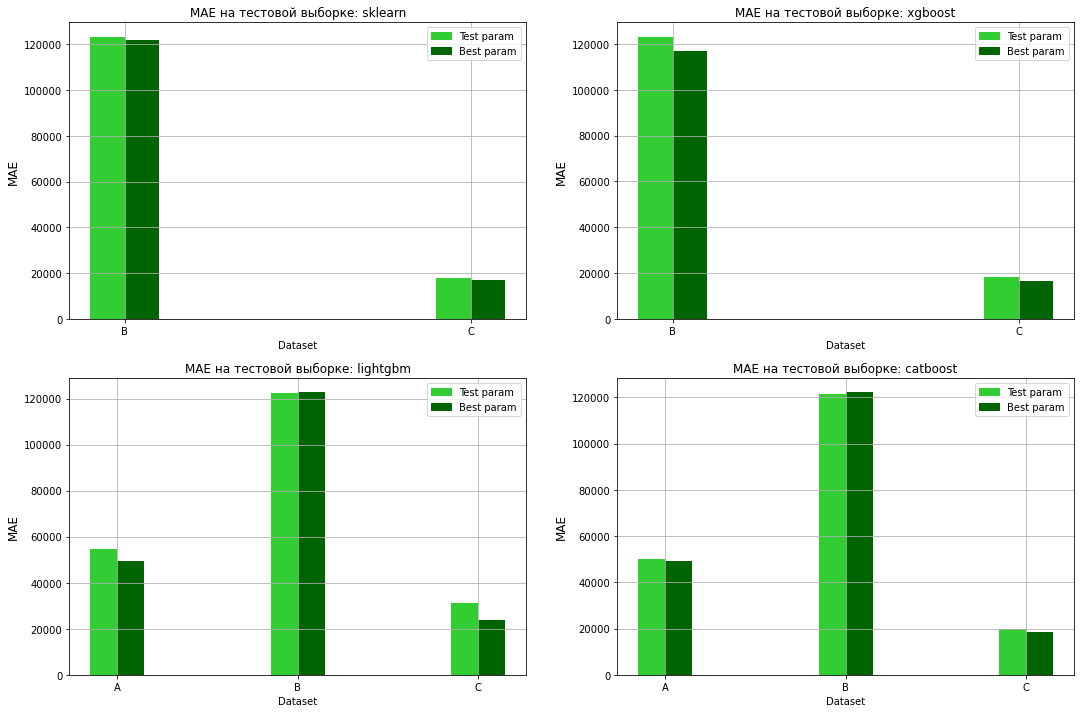

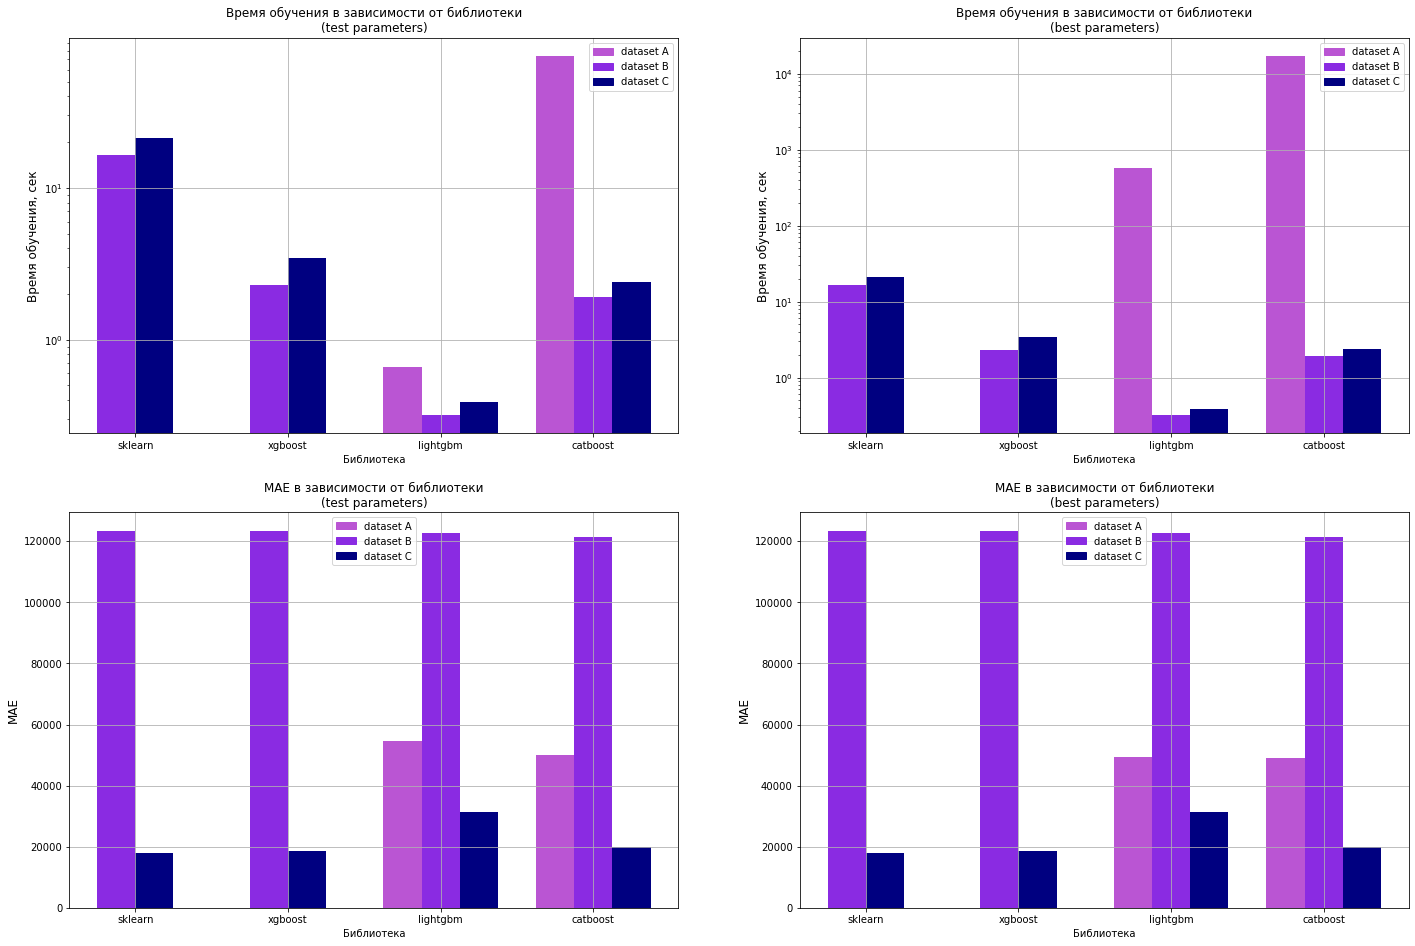

In [24]:
fig = plt.figure(figsize=(18, 12))
names = ['sklearn', 'xgboost', 'lightgbm', 'catboost']

i = 1
for df in dataframes:
        
    ds_list = ['B', 'C']
    width = 0.1
    if i>=3:
        ds_list = ['A'] + ds_list
        width = 0.15
    data = []
    for c in ds_list:
        data += list(df.loc[c, 'MAE'])
        
    plt.subplot(2, 2, i)
    
    plt.title('MAE на тестовой выборке: '+names[i-1], fontsize = 12)

    
    data_test = data[::2]
    data_best = data[1::2]
    
    ids = np.arange(1, len(ds_list)+1)
    plt.bar(ids-width/2, data_test, width, color = 'limegreen')
    plt.bar(ids+width/2, data_best, width, color = 'darkgreen')

    plt.xlabel('Dataset', fontsize = 10)
    plt.ylabel('MAE', fontsize = 12)

    plt.grid(True)
    plt.xticks(ids, ds_list)
    
    colors = {'Test param':'limegreen', 'Best param':'darkgreen'}        
    labels = list(colors.keys())
    handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]
    plt.legend(handles, labels)
    
    i += 1
plt.show()



fig = plt.figure(figsize=(24, 16))
make_plot('Time', 'test')
make_plot('Time', 'best')
make_plot('MAE', 'test')
make_plot('MAE', 'best')
    
plt.show()

**Ваши выводы:**
1) Подбор оптимальных параметров и обучение модели с ними требует намного больше времени, чем обучение модели с тестовыми параметрами.  
2) Оптимальные параметры дают немного меньшую МАЕ, но всё равно близкую к той, которую получили для модели с тестовыми параметрами.  
3) lightgbm является самой быстрой библиотекой, потом идут xgboost и cat boost, таким образом sklearn - самая медленная. При этом самая большая ошибка также получается у lightgbm, у остальных библиотек результаты примерно одинаковы.  
4) Больше всего времени уходит на обучение моделей на датасете с категориальными признаками в виде категорий (датасет А).  
5) Самая большая ошибка получается на датасете, в котором удалены все категориальные переменные (датасет В), самая маленькая - на датасете, где категориальные переменные закодированы (датасет С).  
6) Таким образом, лучшие результаты по соотношению скорость/качество показывают библиотеки xgboost и cat boost.

## Оптимизация параметров с hyperopt

И так, мы с вами научились пользоваться библиотеками для градиентного бустинга. И я почти уверен, что знаю вашу самую "любимую" часть всех этих заданий: оптимизация параметров. Она достаточно долгая, нудная, да еще и над сетками перебора нужно думать. Значит сейчас, когда вы поняли всю тяжесть этого процесса, мы можем узнать как относительно быстро и безболезненно нащупать оптимальные параметры!


[Эмоции выполняющего в этот момент.](https://disk.yandex.ru/i/qwkvBEFrWYoV9A)


Нашего спасителя зовут HyperOpt. На первый взгляд hyperopt делает всё то же самое, что и grid search, а именно перебирает параметры. По факту же hyperopt превращает это в задачу оптимизации, используя некоторые эвристики для ускорения сходимости процесса. К тому же, он требует лишь информацию о границе интарвалов, а не сами сетки. В теории это должно помочь нам добиться лучших результатов за более короткое время. Давайте попробуем это сделать.

Для данного эксперимента я рекомендую использовать lightgbm, поскольку она быстрее и с ней удобнее играться, но Вы можете воспользоваться любой библиотекой из представленных выше.

### Задание 7 (кросс-проверка, 4 балла):
**Данные**: датасет со стоимостью поддержанных автомобилей
**Метрика**: MAE
**Цели**: В данном задании следует выполнить следующие пункты:
1. Взять любую библиотеку градиентного бустинга (можете взять самую быструю)
2. Составить сетку перебора в hyperopt, включающую параметры n_estimators, max_depth и learning_rate в hyperopt. Вам могут понадобиться такие типы данных, как hp.choise, hp.qloguniform, hp.uniform и hp.quniform (можно также пользоваться np.arange). Также для округления значения типа float до целых чисел (4.0 -> 4) используйте `scope.int`.
3. Реализуйте функцию, которая принимает на вход словарь параметров для регрессора, и при помощи cv оценивает его качество на датасете A (можно воспользоваться cross_val_score, а для ускорения поставить cv=3). Не забудьте о том, в каком виде lightgbm принимает категориальные признаки в numpy и что также надо передавать индексы категориальных признаков.
4. Создайте объект trials=Trials(), который будет хранить информацию о процессе оптимизации.
5. Используя функцию fmin, оптимизируйте Вашу функцию. Установите algo=tpe.suggest, trials=trials и max_evals, по крайней мере, 50. verbose=1 позволит видеть прогресс-бар по типу tqdm.
6. Выведите получившиеся параметры. Нарисуйте график, показывающий значение loss в ходе оптимизации. Посчитайте качество на тесте при использовании лучших параметров (возвращаются после использования fmin). Сделайте выводы по результату.

In [25]:
import warnings
warnings.filterwarnings("ignore")

trials = Trials()

def quality(params):
    # your cool function here
    return # something

grid = {
    # your clever grid here
}

best = fmin(fn=quality,
                space=grid,
                algo=tpe.suggest,
                max_evals=50,
                trials=trials,
               verbose= 1)


# your super code for super graph

IndexError: list index out of range

**Ваши выводы:**

## Предсказание зрительских симпатий

Ну что, детишки, а теперь перейдём к действительно важным вопросам.

**Внимание!** Следующее задание сдается в системе cv-gml.ru, задание `Град. бустинг (ML)` Для выполнения этого задания необходимо скачать датасет из задания. Здесь вы можете немного почитать про датасет и, при желании, поэкспериментировать. На cv-gml.ru загружайте уже готовый скрипт с подобранными параметрами для обучаемого регрессора. Релизовать код необходимо в шаблонном файле awards_prediction.py, который вы можете найти в проверяющей системе.

В некотором царстве, некотором государстве была развита кинопромышленность. Новые фильмы в этом государстве показывают по интернету, а пользователи после просмотра могут дать фильму некоторую "награду". Наша цель - предсказать число наград для фильма.

В нашем распоряжении имеются следующие данные:

**awards** - количество наград, полученных фильмом от пользователей (целевое значение)  
**potions** - количество магических зелий, потраченных на создание спец-эффектов  
**genres** - жанры созданного фильма  
**questions** - количество вопросов, заданных пользователями на соответствующих форумах об этом фильме до премьеры  
**directors** - режиссеры фильма (если неизвестны, то unknown)  
**filming_locations** - области, в которых снимался фильм  
**runtime** - продолжительность фильма в некоторых единицах, принятых в этом государстве  
**critics_liked** - количество критиков из 100, присудивших награды фильму на предварительных закрытых показах  
**pre-orders** - количество зрителей, заранее купивших билеты на первый показ  
**keywords** - ключевые слова, описывающие содержание фильма
**release_year** - год, во котором фильм был показан (конечно, в летоисчислении этого государства)

Следующие поля появляются несколько раз с разными значениями i:

**actor_i_known_movies** - количество известных фильмов актера i (i от 1 до 3)

**actor_i_postogramm** - количество подписчиков в социальной сети "по сто грамм" актера i (i от 1 до 3)

**actor_i_gender** - пол актера i (i от 1 до 3)

**actor_i_age** - возраст актера i (i от 1 до 3)

-----
**Внимание!** Учтите, что при OHE кодировании признаки на обучении и тестировании должны совпадать! Если вы примените простое .get_dummies() или что-то подобное, то признаки на трейне и тесте получатся разные! Так что вам, вероятно, придётся придумать способ для того, чтобы сохранить их :)  

### Задание 8 (ML задание, 20 баллов):
**Данные**: датасет с ценами поддержанных автомобилей  
**Метрика**: MAE  
**Цели**: В данном задании следует выполнить следующие пункты:  
1. Взять любую библиотеку градиентного бустинга
2. Используя предложенный датасет, обучить регрессор для предсказания awards (предоставляем полную свободу в настройках и выборе методов)
3. Загрузить решение и получить качество на закрытой выборке больше порогового значения

In [ ]:
## your efficient code here



## Конец

Ну что детишки... Можете добавлять еще 4 библиотеки в своё резюме датасаентиста!
